<a href="https://colab.research.google.com/github/Shwethaa-R/Deep-Learning-Activity-4/blob/main/AlexNet_Transfer_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using AlexNet

Implement the AlexNet model using transfer learning concepts such as ConvNet as fixed feature extractor, Fine-tuning the ConvNet., Fine-tuning the ConvNet. Select one model from above 3 using following conditions :

· New dataset is small and similar to original dataset

· New dataset is Large and similar to original dataset

Following is the GitHub link for accessing the code:
https://github.com/Shwethaa-R/Deep-Learning-Activity-4

The Transfer Learning concept chosen to implement AlexNet model is ConvNet as fixed feature extractor. In that, the pretrained model and weights are used as they are, while the last layer is alone modified to have the number of output classes depending on the number of classes in the dataset.

In [ ]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
from __future__ import print_function, division
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import torchvision.models as models 
from torchsummary import summary 

This is a SMALL DATASET, which is divided into 'train' and 'test' folders. It is a part of the MNIST dataset.
It has 10 classes, with each class having 100 images in each.

In [ ]:
# Data augmentation and normalization are performed on training data
# Normalization is alone performed on validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# The path for training and validation data. 
data_dir = '/content/drive/My Drive/Classification Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


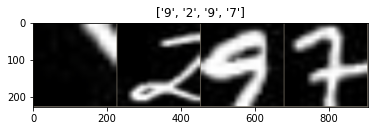

In [ ]:
# Plot few examples
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) #Standard values as given in PyTorch
    std = np.array([0.229, 0.224, 0.225]) #Standard values as given in PyTorch
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Train the model based on the parameters given
def train_model(model, criterion, optimizer, num_epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
              
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            if phase == 'test':
              test_loss.append(epoch_loss)
              test_acc.append(epoch_acc)

            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(
                phase, epoch_loss, phase, epoch_acc))

            # Deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, test_loss, test_acc

In [ ]:
# Function to visualize the model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# Defining the parameters
model_ft = models.alexnet(pretrained=True).cuda()
model_ft.eval()
num_ftrs = 61100840
# There are 10 classes
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
model_ft, train_loss, train_acc, test_loss, test_acc = train_model(model_ft, criterion, optimizer_ft, 10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.9318 train Acc: 0.1400
test Loss: 1.7020 test Acc: 0.4500

Epoch 1/9
----------
train Loss: 2.2220 train Acc: 0.2920
test Loss: 1.2492 test Acc: 0.5900

Epoch 2/9
----------
train Loss: 1.9283 train Acc: 0.3350
test Loss: 1.0456 test Acc: 0.6300

Epoch 3/9
----------
train Loss: 1.7537 train Acc: 0.4070
test Loss: 0.8680 test Acc: 0.6300

Epoch 4/9
----------
train Loss: 1.6535 train Acc: 0.4240
test Loss: 0.7581 test Acc: 0.7200

Epoch 5/9
----------
train Loss: 1.5757 train Acc: 0.4640
test Loss: 0.4727 test Acc: 0.8600

Epoch 6/9
----------
train Loss: 1.3986 train Acc: 0.5320
test Loss: 0.4055 test Acc: 0.8800

Epoch 7/9
----------
train Loss: 1.2502 train Acc: 0.5760
test Loss: 1.0821 test Acc: 0.6200

Epoch 8/9
----------
train Loss: 1.2445 train Acc: 0.5960
test Loss: 0.3715 test Acc: 0.8900

Epoch 9/9
----------
train Loss: 1.1593 train Acc: 0.6270
test Loss: 0.4863 test Acc: 0.8400

Best val Acc: 0.890000


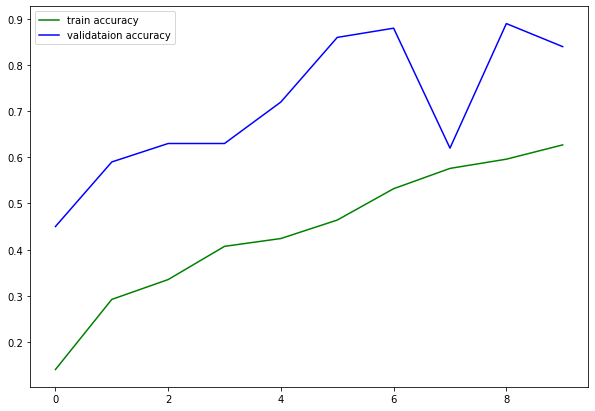

In [ ]:
# Plot the accuracy over 10 epochs
plt.figure(figsize=(10, 7))
plt.plot(train_acc, color='green', label='train accuracy')
plt.plot(test_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.show()

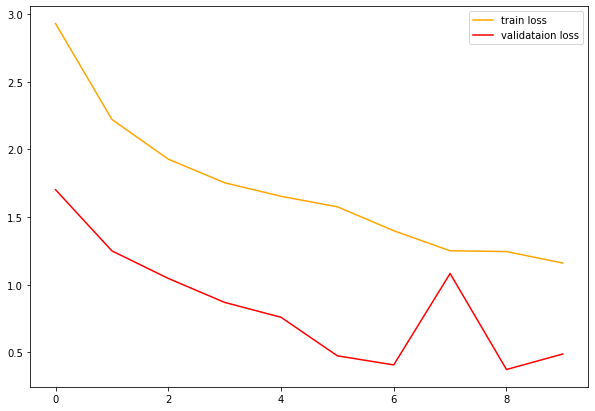

In [ ]:
# Plot the loss over 10 epochs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(test_loss, color='red', label='validataion loss')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


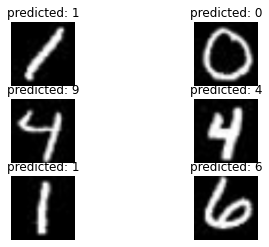

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

This is a LARGE DATASET, where there are 10 classes. It is the CIFAR Dataset. The dataset is divided into training and validation data.

In [ ]:
# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Data resizing and normalization
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Download the AlexNet model
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.to(device)
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Alter the final layer by changing the number of classes 
alexnet_model.classifier[6].out_features = 10
# Freeze convolution weights
for param in alexnet_model.features.parameters():
    param.requires_grad = False

In [ ]:
# Optimizer
optimizer = optim.SGD(alexnet_model.classifier.parameters(), lr=0.001, momentum=0.9)
# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [ ]:
# Training function to train the model
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
for epoch in range(10):
    print("Epoch {}".format(epoch))
    train_epoch_loss, train_epoch_accuracy = fit(alexnet_model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(alexnet_model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Epoch 0
Train Loss: 0.0219, Train Acc: 75.33
Epoch 1
Train Loss: 0.0188, Train Acc: 78.95
Epoch 2
Train Loss: 0.0172, Train Acc: 80.57
Epoch 3
Train Loss: 0.0160, Train Acc: 81.83
Epoch 4
Train Loss: 0.0148, Train Acc: 83.32
Epoch 5
Train Loss: 0.0140, Train Acc: 84.15
Epoch 6
Train Loss: 0.0132, Train Acc: 84.94
Epoch 7
Train Loss: 0.0126, Train Acc: 85.80
Epoch 8
Train Loss: 0.0118, Train Acc: 86.57
Epoch 9
Train Loss: 0.0112, Train Acc: 87.47


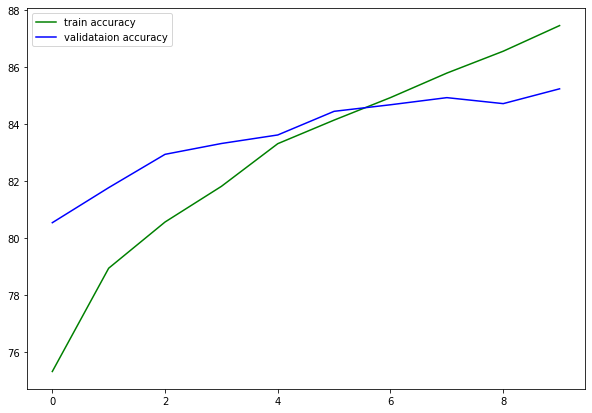

In [ ]:
# Plot the accuracy over 10 epochs
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

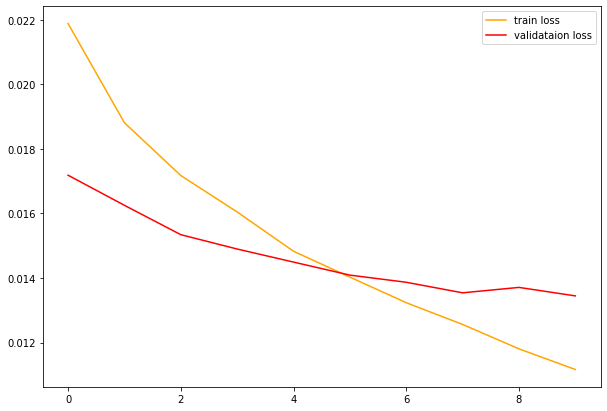

In [ ]:
# Plot the loss over 10 epochs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()